NOTEBOOK PARA COMPARATIVAS TTF DE PERIODOS

In [1]:
# -*- coding: utf-8 -*-
import re
from pathlib import Path
from datetime import datetime, timezone, timedelta
import pandas as pd
import dask.dataframe as dd

# === Config ===
PREFIJO_ARCHIVO = "1_filtrado_almacenamiento_posiciones_"  # opcional; pon None para no filtrar por nombre
DATA_DIR = Path(r"c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa")

# Candidatas a columna temporal (ordénalas por preferencia)
TIME_COL_CANDIDATES = ["timestamp", "Timestamp", "time", "Time", "datetime", "DateTime", "fecha", "Fecha"]

print("Ruta elegida:", DATA_DIR)
if not DATA_DIR.exists():
    raise FileNotFoundError(f"No existe la carpeta {DATA_DIR}")

# 1) Localiza archivos parquet (opcionalmente por prefijo)
files = sorted([p for p in DATA_DIR.glob("*.parquet") if (not PREFIJO_ARCHIVO or p.name.startswith(PREFIJO_ARCHIVO))])
if not files:
    raise FileNotFoundError(f"No hay .parquet dentro de {DATA_DIR} (prefijo={PREFIJO_ARCHIVO!r}).")

def detectar_col_tiempo(path: Path) -> str:
    """Intenta detectar el nombre de la columna temporal leyendo solo el esquema."""
    # Leemos solo el meta (Dask elaborará columnas disponibles)
    tmp = dd.read_parquet(str(path), engine="pyarrow")
    cols = list(tmp.columns)
    for c in TIME_COL_CANDIDATES:
        if c in cols:
            return c
    # Si no encontramos, ayudamos con mensaje claro
    raise KeyError(
        f"No se encontró columna temporal en {path.name}. "
        f"Busca alguna de: {TIME_COL_CANDIDATES}. Columnas detectadas: {cols[:50]}"
    )

def rango_temporal_archivo(path: Path, time_col: str):
    """Devuelve (min_ts, max_ts) reales del archivo leyendo solo la columna temporal."""
    ddf = dd.read_parquet(str(path), engine="pyarrow", columns=[time_col])
    # Convertimos a datetime fiable
    ddf = ddf.assign(**{time_col: dd.to_datetime(ddf[time_col], errors="coerce", utc=False)})
    min_ts = ddf[time_col].min().compute()
    max_ts = ddf[time_col].max().compute()
    if pd.isna(min_ts) or pd.isna(max_ts):
        raise ValueError(f"El archivo {path.name} tiene timestamps nulos/no convertibles en la columna {time_col}.")
    return pd.to_datetime(min_ts), pd.to_datetime(max_ts)

# 2) Catalogar por rango temporal REAL (min/max) leyendo la columna timestamp
catalog = []
for f in files:
    try:
        time_col = detectar_col_tiempo(f)
        tmin, tmax = rango_temporal_archivo(f, time_col)
        catalog.append({
            "path": str(f),
            "name": f.name,
            "time_col": time_col,
            "tmin": tmin,
            "tmax": tmax,
            "duracion_dias": (tmax.normalize() - tmin.normalize()).days,
        })
    except Exception as e:
        print(f"[AVISO] Omitiendo {f.name}: {e}")

catalog_df = pd.DataFrame(catalog)
if catalog_df.empty:
    raise RuntimeError("No se pudo catalogar ningún archivo por rango temporal (revisa columnas de tiempo).")

# 3) Selección de Periodo A (más nuevo) y B (más viejo) por tmax descendente
catalog_df = catalog_df.sort_values(["tmax", "tmin"], ascending=[False, False]).reset_index(drop=True)

print("\n=== Catálogo por rango temporal (top) ===")
print(catalog_df.head(10).to_string(index=False))

if len(catalog_df) < 2:
    raise RuntimeError("Necesitas al menos dos datasets para comparar Periodo A y B.")

periodo_A = catalog_df.iloc[0].to_dict()  # más reciente por tmax
periodo_B = catalog_df.iloc[1].to_dict()  # siguiente más reciente

def fmt_ts(ts):
    # imprime con fecha y hora si aporta; si prefieres solo fecha usa .date().isoformat()
    return pd.to_datetime(ts).isoformat()

print("\n=== Selección de Periodos (por tmax) ===")
print(f"Periodo A (más nuevo): {periodo_A['name']}")
print(f"  • Rango real: {fmt_ts(periodo_A['tmin'])} → {fmt_ts(periodo_A['tmax'])}  (~{periodo_A['duracion_dias']} días)")
print(f"Periodo B (más viejo): {periodo_B['name']}")
print(f"  • Rango real: {fmt_ts(periodo_B['tmin'])} → {fmt_ts(periodo_B['tmax'])}  (~{periodo_B['duracion_dias']} días)")

# 4) Cargar DataFrames Dask completos (ya sabemos su columna de tiempo)
df_A = dd.read_parquet(periodo_A["path"], engine="pyarrow")
df_B = dd.read_parquet(periodo_B["path"], engine="pyarrow")

# 5) Metadatos listos para usar
PERIODO_A_INFO = {
    "label": "Periodo A (más nuevo)",
    "path": periodo_A["path"],
    "nombre_archivo": periodo_A["name"],
    "time_col": periodo_A["time_col"],
    "rango_inicio": periodo_A["tmin"],
    "rango_fin": periodo_A["tmax"],
    "df": df_A,
}
PERIODO_B_INFO = {
    "label": "Periodo B (más viejo)",
    "path": periodo_B["path"],
    "nombre_archivo": periodo_B["name"],
    "time_col": periodo_B["time_col"],
    "rango_inicio": periodo_B["tmin"],
    "rango_fin": periodo_B["tmax"],
    "df": df_B,
}

# (Opcional) tamaños rápidos
try:
    nrows_A = df_A.shape[0].compute(); ncols_A = len(df_A.columns)
    nrows_B = df_B.shape[0].compute(); ncols_B = len(df_B.columns)
    print(f"\nForma A: ({nrows_A:,}, {ncols_A}) | {Path(periodo_A['path']).name}")
    print(f"Forma B: ({nrows_B:,}, {ncols_B}) | {Path(periodo_B['path']).name}")
except Exception as e:
    print("(Info) No se pudo computar la forma ahora:", e)


Ruta elegida: c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa

=== Catálogo por rango temporal (top) ===
                                                                                                                                   path                                                              name  time_col                      tmin                             tmax  duracion_dias
c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa\1_filtrado_almacenamiento_posiciones_19dias_20250925_1736.parquet 1_filtrado_almacenamiento_posiciones_19dias_20250925_1736.parquet timestamp 2025-08-27 00:00:00+00:00 2025-09-14 23:58:58.289296+00:00             18
c:\1_IXORIGUE\1_Proyectos\ixo-analitica-soporte\data\data_comparativa\1_filtrado_almacenamiento_posiciones_31dias_20250925_1755.parquet 1_filtrado_almacenamiento_posiciones_31dias_20250925_1755.parquet timestamp 2025-07-22 00:00:00+00:00 2025-08-21 23:58:58.792210+00:00             30

=== Selección 

In [2]:
# =========================
# 6) Filtrado inicial por ranch_name y model → convertir a pandas.DataFrame
# =========================

# Lista de ranch_name a filtrar
ranch_names = [
    "Casa Nasi Joana Casimiro Forestal",
    "Fernando Soto",
    "Adolfo Gutiérrez Gómez",
    "Tomás Gómez Cora",
    "Rocío Moreno de Castro Josep Buenaventura Forestal",
    "Miquel Boixadera Ballarà",
    "Armando Bartolomé González",
    "Pedro Manenti",
    "Reyes Manenti",
    "Javier Algueta",
    "José López Arnejo",
    "Alicia Fernández Corrales",
    "Miren Meabe Cerro",
    "Javier Laplaza Ipas",
    "Andrés Sanz",
    "Gerard Cardona  Tremp",
    "Ángeles María Collado",
    "Josep corts - casa nasi",
    "Jordi Pinassa - Rocamora",
    "Raúl Berridi Inguanzo",
    "Javier Pérez Bonilla",
    "Héctor Febles Acosta",
    "Miguel Zoco"
]

# Lista de modelos permitidos
models = ["ixo_track_pro", "cow_pro"]

# Función de filtrado genérica
def filtrar_dataset(df, ranch_names, models):
    return df[
        df["ranch_name"].isin(ranch_names) &
        df["model"].isin(models)
    ]

# Filtrar en Dask
df_A_filtrado = filtrar_dataset(df_A, ranch_names, models)
df_B_filtrado = filtrar_dataset(df_B, ranch_names, models)

# Convertir a pandas.DataFrame
df_A_filtrado_pd = df_A_filtrado.compute()
df_B_filtrado_pd = df_B_filtrado.compute()

# Ver primeras filas y tamaños
print("\n=== Periodo A filtrado (pandas) ===")
print(df_A_filtrado_pd.head())
print("Filas filtradas A:", len(df_A_filtrado_pd))

print("\n=== Periodo B filtrado (pandas) ===")
print(df_B_filtrado_pd.head())
print("Filas filtradas B:", len(df_B_filtrado_pd))



=== Periodo A filtrado (pandas) ===
                                  device_id  ...      dev_eui_norm
index                                        ...                  
4355   10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
9990   10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
21602  10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
66878  10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
70406  10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1

[5 rows x 22 columns]
Filas filtradas A: 214225

=== Periodo B filtrado (pandas) ===
                                  device_id  ...      dev_eui_norm
index                                        ...                  
60978  10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
61872  10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
62338  10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
65366  10f15552-b50c-45a4-9f65-fcbc5d3a915a  ...  8c1f6446500000d1
70117 

In [8]:
# =========================
# 7) Resultado por ganadería: promedio TimeToFix, diferencia B-A y nº dispositivos (unique serial_number)
# =========================

import dask.dataframe as dd
import pandas as pd

rango_B = f"{PERIODO_B_INFO['rango_inicio'].date()} → {PERIODO_B_INFO['rango_fin'].date()}"
rango_A = f"{PERIODO_A_INFO['rango_inicio'].date()} → {PERIODO_A_INFO['rango_fin'].date()}"

# Asegurar numérico
df_A_ttfn = df_A_filtrado.assign(TimeToFix=dd.to_numeric(df_A_filtrado["TimeToFix"], errors="coerce"))
df_B_ttfn = df_B_filtrado.assign(TimeToFix=dd.to_numeric(df_B_filtrado["TimeToFix"], errors="coerce"))

# --- Promedio por ganadería (A y B)
grp_A_mean = df_A_ttfn.groupby("ranch_name")["TimeToFix"].mean().rename("Periodo A")
grp_B_mean = df_B_ttfn.groupby("ranch_name")["TimeToFix"].mean().rename("Periodo B")

# --- Nº de dispositivos únicos por ganadería (A y B) -> unique de serial_number del df
grp_A_n_dev = df_A_ttfn[["ranch_name","serial_number"]].drop_duplicates().groupby("ranch_name")["serial_number"].count().rename("n_dispositivos_A")
grp_B_n_dev = df_B_ttfn[["ranch_name","serial_number"]].drop_duplicates().groupby("ranch_name")["serial_number"].count().rename("n_dispositivos_B")

# --- Unir resultados
resultado = dd.merge(grp_B_mean.to_frame(), grp_A_mean.to_frame(), left_index=True, right_index=True, how="outer")
resultado = dd.merge(resultado, grp_B_n_dev.to_frame(), left_index=True, right_index=True, how="outer")
resultado = dd.merge(resultado, grp_A_n_dev.to_frame(), left_index=True, right_index=True, how="outer")

# --- Diferencia B - A del promedio
resultado = resultado.assign(Diferencia_B_menos_A = resultado["Periodo B"] - resultado["Periodo A"])

# --- Presentación
resultado = resultado.reset_index().rename(columns={"ranch_name": "ganaderia"})
resultado = resultado.compute().sort_values("Diferencia_B_menos_A", ascending=False)

# --- Renombrar con rangos
resultado = resultado.rename(columns={
    "Periodo B": f"Periodo B promedio ({rango_B})",
    "Periodo A": f"Periodo A promedio ({rango_A})",
    "Diferencia_B_menos_A": "Diferencia (B - A)",
    "n_dispositivos_B": f"Nº dispositivos B ({rango_B})",
    "n_dispositivos_A": f"Nº dispositivos A ({rango_A})"
})

print("\n=== Resultado por ganadería ===")
print(resultado.to_string(index=False))



=== Resultado por ganadería ===
                                         ganaderia  Periodo B promedio (2025-07-22 → 2025-08-21)  Periodo A promedio (2025-08-27 → 2025-09-14)  Nº dispositivos B (2025-07-22 → 2025-08-21)  Nº dispositivos A (2025-08-27 → 2025-09-14)  Diferencia (B - A)
                          Miquel Boixadera Ballarà                                     47.997107                                     15.396462                                           40                                           40           32.600645
                                     Fernando Soto                                     56.410217                                     24.970605                                            5                                            5           31.439612
                            Adolfo Gutiérrez Gómez                                     54.621225                                     26.478434                                            5                     

In [9]:
# --- Guardar resultados en CSV en el Escritorio ---
import os

usuario = os.getlogin()
desktop = os.path.join("C:\\Users", usuario, "Desktop")
out_path = os.path.join(desktop, "resultado_ganaderia.csv")

resultado.to_csv(out_path, index=False, encoding="utf-8-sig")  # utf-8-sig para acentos en Excel
print(f"\n✅ CSV exportado en: {out_path}")



✅ CSV exportado en: C:\Users\usuario\Desktop\resultado_ganaderia.csv


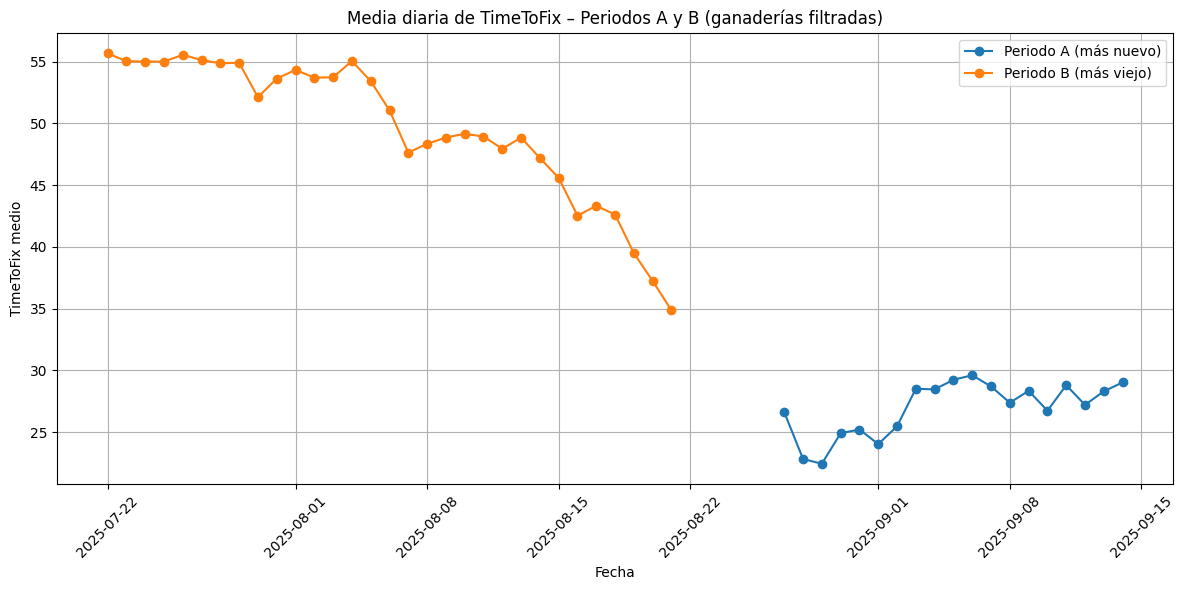

In [36]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Asegurar tipos correctos ---
df_A_filtrado_pd["timestamp"] = pd.to_datetime(df_A_filtrado_pd["timestamp"], utc=True, errors="coerce")
df_B_filtrado_pd["timestamp"] = pd.to_datetime(df_B_filtrado_pd["timestamp"], utc=True, errors="coerce")

df_A_filtrado_pd["TimeToFix"] = pd.to_numeric(df_A_filtrado_pd["TimeToFix"], errors="coerce")
df_B_filtrado_pd["TimeToFix"] = pd.to_numeric(df_B_filtrado_pd["TimeToFix"], errors="coerce")

df_A_filtrado_pd["fecha"] = df_A_filtrado_pd["timestamp"].dt.date
df_B_filtrado_pd["fecha"] = df_B_filtrado_pd["timestamp"].dt.date

# --- Promedio diario ---
df_a_daily = (
    df_A_filtrado_pd.groupby("fecha")["TimeToFix"]
      .mean()
      .reset_index()
      .sort_values("fecha")
)
df_a_daily["periodo"] = "A"

df_b_daily = (
    df_B_filtrado_pd.groupby("fecha")["TimeToFix"]
      .mean()
      .reset_index()
      .sort_values("fecha")
)
df_b_daily["periodo"] = "B"

# --- Concatenar ---
df_total = pd.concat([df_a_daily, df_b_daily], ignore_index=True)

# --- Graficar ---
plt.figure(figsize=(12, 6))

mask_a = df_total["periodo"] == "A"
mask_b = df_total["periodo"] == "B"

plt.plot(
    df_total.loc[mask_a, "fecha"],
    df_total.loc[mask_a, "TimeToFix"],
    marker="o",
    label="Periodo A (más nuevo)"
)

plt.plot(
    df_total.loc[mask_b, "fecha"],
    df_total.loc[mask_b, "TimeToFix"],
    marker="o",
    label="Periodo B (más viejo)"
)

plt.title("Media diaria de TimeToFix – Periodos A y B (ganaderías filtradas)")
plt.xlabel("Fecha")
plt.ylabel("TimeToFix medio")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


CASO ARMANDO

In [37]:
import pandas as pd

GANADERIA_OBJETIVO = "Armando Bartolomé González"

# --- Asegurar tipos ---
df_A_filtrado_pd["timestamp"] = pd.to_datetime(df_A_filtrado_pd["timestamp"], utc=True, errors="coerce")
df_A_filtrado_pd["TimeToFix"] = pd.to_numeric(df_A_filtrado_pd["TimeToFix"], errors="coerce")

# --- Detectar columna de serie (SerialNumber) ---
serial_candidates = ["SerialNumber", "serial_number", "serial", "device_sn"]
serial_col = next((c for c in serial_candidates if c in df_A_filtrado_pd.columns), None)
if serial_col is None:
    raise KeyError(f"No encuentro columna de serie. Busqué: {serial_candidates}")

# --- Filtrar por ganadería y ordenar ---
df_ranch_A = (
    df_A_filtrado_pd.loc[df_A_filtrado_pd["ranch_name"] == GANADERIA_OBJETIVO,
                         [serial_col, "timestamp", "TimeToFix"]]
    .dropna(subset=["timestamp"])
    .sort_values("timestamp", ascending=False)   # 👈 más nuevo → más antiguo
    .reset_index(drop=True)
)

print(f"\n=== Periodo A – Registros de '{GANADERIA_OBJETIVO}' (ordenados de más nuevo a antiguo) ===")
print(df_ranch_A.head(50).to_string(index=False))  # muestra las 50 primeras filas

# --- Último registro (más reciente) ---
if not df_ranch_A.empty:
    ultimo = df_ranch_A.iloc[0]
    print("\n► Último registro (más reciente):")
    print(f"  {serial_col}: {ultimo[serial_col]}")
    print(f"  timestamp:   {ultimo['timestamp']}")
    print(f"  TimeToFix:   {ultimo['TimeToFix']}")
else:
    print("\n(No hay datos para esa ganadería en el Periodo A)")



=== Periodo A – Registros de 'Armando Bartolomé González' (ordenados de más nuevo a antiguo) ===
serial_number                        timestamp  TimeToFix
     70015999        2025-09-14 23:16:19+00:00         37
     70015997        2025-09-14 23:10:37+00:00          6
     70016001        2025-09-14 23:08:08+00:00          7
     70016004        2025-09-14 23:07:52+00:00         41
     70015998        2025-09-14 23:07:16+00:00         46
     70016006        2025-09-14 23:06:17+00:00         12
     70016005        2025-09-14 23:05:28+00:00         20
     70016002        2025-09-14 23:05:04+00:00         17
     70016000        2025-09-14 23:04:55+00:00         36
     70016003        2025-09-14 23:02:09+00:00         41
     70015999        2025-09-14 22:15:56+00:00         14
     70015997        2025-09-14 22:11:01+00:00         30
     70016001        2025-09-14 22:08:31+00:00         29
     70016004        2025-09-14 22:07:34+00:00         23
     70015998        2025-09-14 